# GRIP THE SPARK FOUNDATION 

# CV & IOT 
Name: Padmasandhiya P 

### Colour identification

#### Step 1 - Importing libraries.

In [1]:
import cv2
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76
from collections import Counter
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

#### Step 2- Reading image 

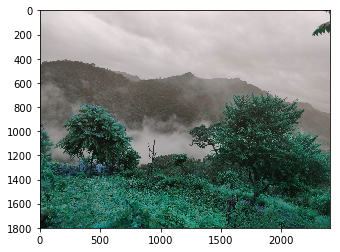

In [2]:
image = cv2.imread(r'C:\Users\HP\Desktop\sample_3.jpg')
plt.imshow(image)
plt.show()

#### Step 3- Checking type and shape of image data 

In [8]:
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))

The type of this input is <class 'numpy.ndarray'>
Shape: (1800, 2400, 3)


We can see that the image has different colors as compared to the original image. This is because by default OpenCV reads the images in the color order "BLUE-GREEN-RED" i.e. BGR. Thus, we need to convert it into "RED GREEN BLUE" i.e. RGB.

#### Step 4- Converting BGR to RGB.

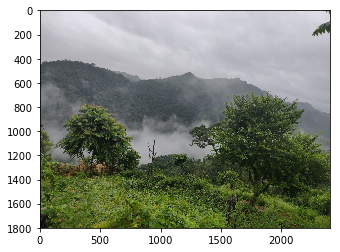

In [9]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Now we need to convert RGB image to grayscale because in RGB image we have to work with 3 channel so computer need more time and memory to understand what's inside image but with grayscale we are only left with 2D array so it's easy for computer to understand and process.

#### Step 5- Converting image to grayscale.

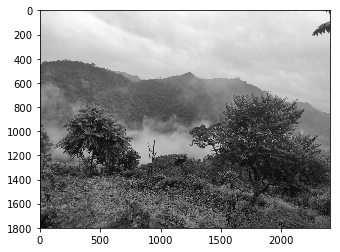

In [10]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()

#### Step 6- Resizing image.

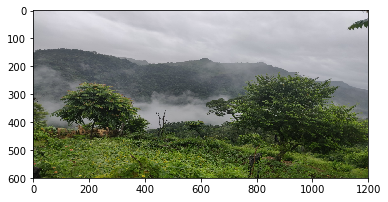

In [19]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

#### Step 7- Colour identification.

First, we will define a function that will give us the hex values of the colors that we have to identify.

In [20]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

KMeans expects flattened array as input during its fit method. Thus, we need to reshape the image using numpy. Then, we can apply KMeans to first fit and then predict on the image to get the results. Then, the cluster colors are identified an arranged in the correct order. We plot the colors as a pie chart. I have combined all the steps in two method.

#### Step 8- Defining method for getting images & converting them from BGR to RGB format.

In [21]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

#### Step 9- Defining method along with K_Means clustering algorithm implementation.

In [22]:
def get_colors(image, number_of_colors, show_chart): 
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

#### Step 10- Calling the above two defined functions inside each other.

[array([206.09214092, 205.79027526, 213.25877399]),
 array([76.74777813, 93.91344364, 37.69424246]),
 array([28.6193271 , 36.99842991, 19.56699065]),
 array([178.95972165, 179.53707191, 185.98575522]),
 array([119.90853134, 124.3931646 , 124.23669938]),
 array([52.97528432, 65.57004269, 32.77618579]),
 array([108.0396152 , 123.46964627,  55.34357075]),
 array([82.86565623, 89.62888075, 90.96292472])]

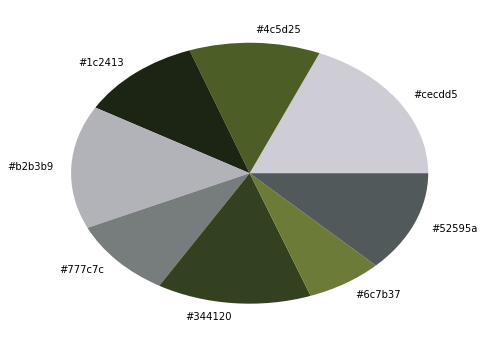

In [23]:
get_colors(get_image(r'C:\Users\HP\Desktop\sample_3.jpg'), 8, True)

#### Step 11- Search images using color

From the model above, we can extract the major colors. This create the opportunity to search for images based on certain colors. We can select a color and if it's hex matches or is close to the hex of the major colors of the image, we say it's a match. We first get all the images and store them in the "images" variable.

In [30]:
IMAGE_DIRECTORY = r'C:\Users\HP\Desktop\images'

COLORS = {'GREEN': [0, 128, 0],'BLUE': [0, 0, 128],'YELLOW': [255, 255, 0], 'WHEAT': [245, 222, 179]}

images = []

for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

#### Step 12- Visualization of data.

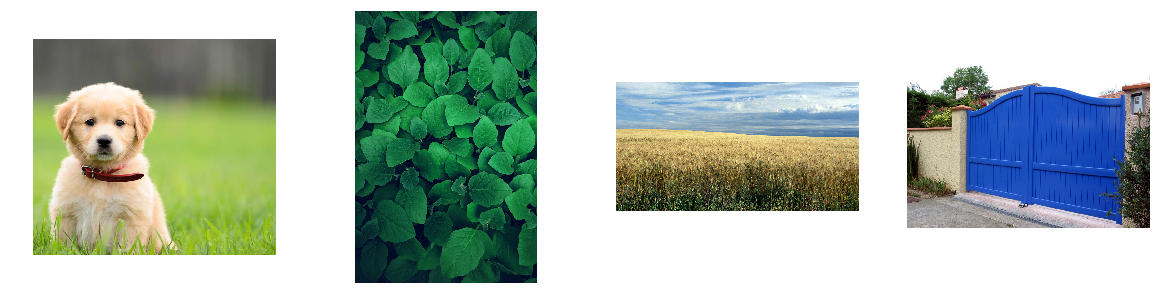

In [27]:
plt.figure(figsize=(20, 5))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])
    plt.axis('off')

#### Step 13- Function for finding matches by using top 10 colors in images.

The function is defined below. We will try to match with the top 10 colors of the image. It is highly possible that there will be no exact match for the hex codes, thus we calculate the similarity between the chosen color and the colors of the image. We keep a threshold value such that if the difference between the chosen color and any of the selected colors is less than that threshold, we declare it as a match. Hex values or RGB values cannot be directly compared so we first convert them to a device independant and color uniform space. We use "RGB2LAB" to convert the values and then find the difference using "deltaE_cie76". This method calculates the difference between all the top 5 colors of the image and the selected color and if atleast one is below the threshold, we show the image.

In [28]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    
    for i in range(number_of_colors):
        
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        
        if (diff < threshold):
            select_image = True
    
    return select_image

#### Step 14- Function for selection of images (Match/Mismatch).

I call the below method for all the images in our set and show relevant images out of the same that approximately match our selected color.

In [29]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            plt.axis('off')
            index += 1

#### Step 15- Calling above methods and visualizing results.

Finding GREEN color.

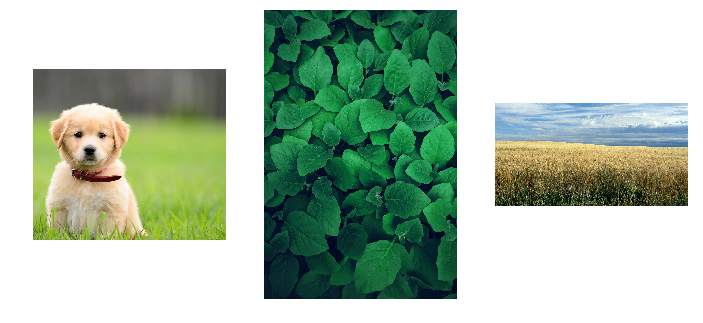

In [33]:
plt.figure(figsize = (20, 8))
show_selected_images(images, COLORS['GREEN'], 60, 5)

Finding BLUE color.

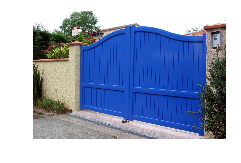

In [34]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['BLUE'], 60, 5)

Finding YELLOW color.

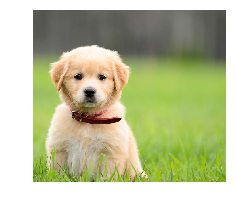

In [35]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['YELLOW'], 60, 5)